# The Lomb-Scargle Periodogram

## When the Fourier Transform Doesn't Work 

There are many situations in physics when you have some time dependant data and would like to find from which frequencies the signal is made.
Alternatively, you could have some data as a function of position and you would like to find which wave numbers are there.
The usual way to solve both of these problems is using the Fourier transform
\begin{equation}
	\mathcal{F} [f(\omega)] = \int_{-\infty}^\infty dt f(t) e^{i \omega t} .
\end{equation}
This gives a convenient way to extract the frequency dependance of a signal.
In the figure below, I demonstrae how this can be done in python.
We setup some data made from sine waves of two frequencies $4$ and $8$.
When the Fourier transform is performed, and we look at which frequencies contribute most strongly, we find two delta like peaks at the two frequencies that appear in our signal.

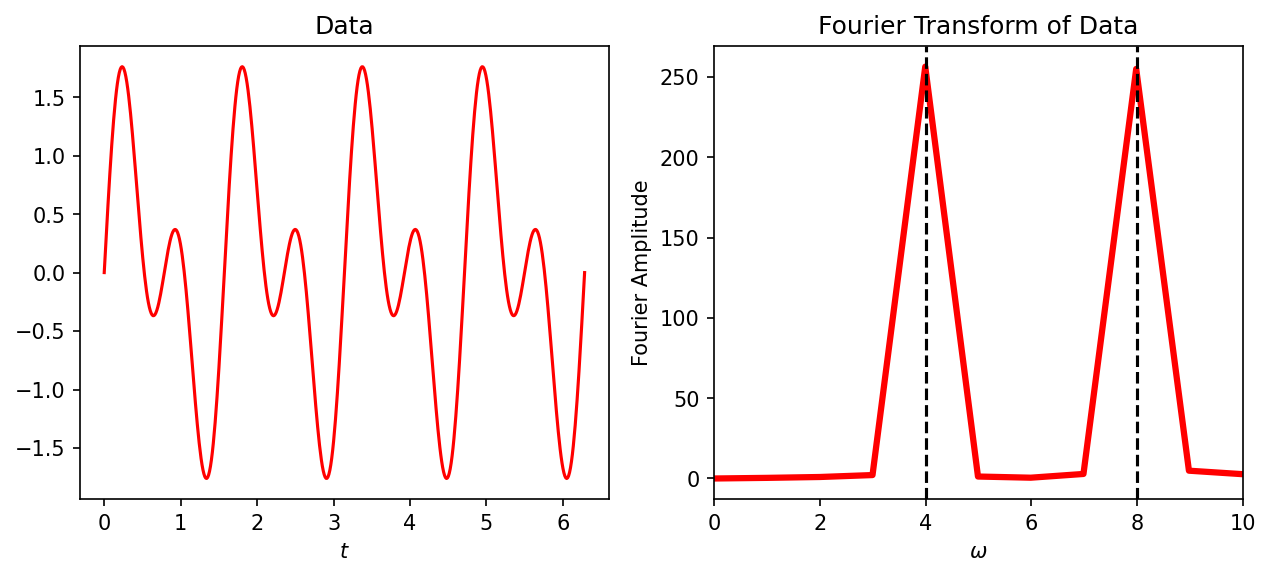

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt 
import scipy.fft as spf
import scipy.signal as sps

w0  = 4.0
## Data with random noise on regularly spaced x values
xv  = np.linspace(0, 2.0*np.pi, 512)
data = np.sin(w0*xv) + np.sin(2.0*w0*xv)

# Do the fft of the data and get the frequencies
fft_dat = spf.fftshift( spf.fft(data) )
fft_w   = spf.fftshift( spf.fftfreq(len(xv), xv[1]-xv[0]) ) * 2 * np.pi 

fig, axs = plt.subplots(1,2, dpi=150, figsize=(10,4))

axs[0].plot(xv, data, 'r-')
axs[0].set_xlabel("$t$")
axs[0].set_title("Data")

axs[1].plot(fft_w, np.abs(fft_dat), 'r-', lw=3)
axs[1].set_xlim(-10,10)
axs[1].axvline(w0, color="k", linestyle="--")
axs[1].axvline(2.0*w0, color="k", linestyle="--")
axs[1].set_xlabel("$\\omega$")
axs[1].set_ylabel("Fourier Amplitude")
axs[1].set_title("Fourier Transform of Data")
axs[1].set_xlim(0,10)

plt.show()

Notice that when we setup the data array we used `xv  = np.linspace(0, 2.0*np.pi, 512)`, meaning that the data is evenly spaced.
What happens if the data is not evenly spaced?
Let's have a look.
We're using exactly the same signal, expect we're now sampling it on random points on the interval.

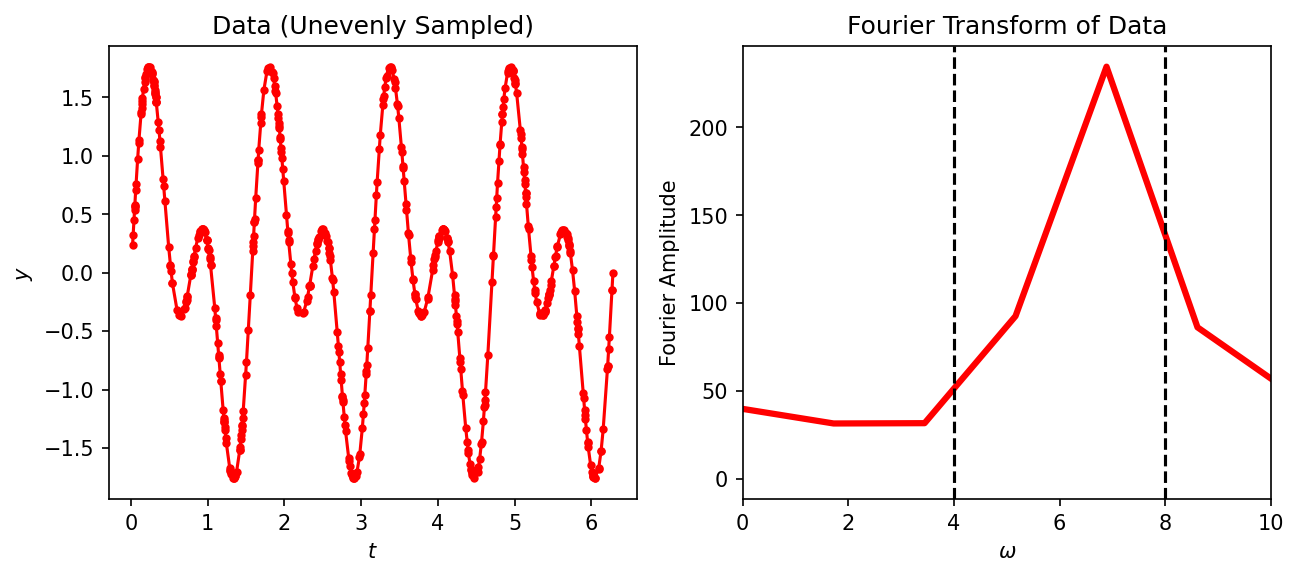

In [2]:
w0      = 4.0

# Data with random noise on UNEVEN x points
xv      = np.sort( npr.uniform(0.0, 2.0*np.pi, 512) )
data    = np.sin(w0*xv) + np.sin(2.0*w0*xv) #+ npr.normal(loc=0, scale=0.3, size=len(xv))

# Do the fft.  The frequencies will not be correct.
fft_dat = spf.fftshift( spf.fft(data) )
fft_w   = spf.fftshift( spf.fftfreq(len(xv), xv[1]-xv[0]) ) * 2 * np.pi 

fig, axs = plt.subplots(1,2, dpi=150, figsize=(10,4))

axs[0].plot(xv, data, 'r.-')
axs[0].set_xlabel("$t$")
axs[0].set_ylabel("$y$")
axs[0].set_title("Data (Unevenly Sampled)")

axs[1].plot(fft_w, np.abs(fft_dat), 'r-', lw=3)
axs[1].set_xlim(0,10)
axs[1].axvline(w0, color="k", linestyle="--")
axs[1].axvline(2.0*w0, color="k", linestyle="--")
axs[1].set_xlabel("$\\omega$")
axs[1].set_ylabel("Fourier Amplitude")
axs[1].set_title("Fourier Transform of Data")

plt.show()

The Fourier peaks are in the wrong place!
This is because the discrete Fourier transform requires data to be sampled on a regular grid.
If the grid is not regular, then the discrete Fourier transform won't work.

This is bad news in plenty of situations.
For example, say you'd like to find the period of oscillation of a Cepheid variable, a type of star whose luminosity oscillates.
This information is useful for benchmarking cosmic distances.
You can only take data when there's no cloud blocking your telescope, leading to data that is irregular in time.
Or say you want to track the habits of animals, which again you can only observe sometimes.
Neither of these problems can make use of the Fourier transform, which is the natural tool for extracting frequencies from time series data.

Luckily, there is another tool that can handle data on an irregular grid: *the Lomb Scargle method*.

## The Lomb Periodogram 

The Lomb-Scargle method was developed by the astronomers Lomb and Scargle separately.
Lomb [1] came up with the method and Scargle proved several important things about it.
The method can be understood as follows.

You have some data points, $(t_i, y_i)$, that are not evenly sampled.
We assume that our data has the form 
\begin{equation}
	y_i = A \cos (\omega (t_i - \tau)) + B \sin (\omega (t_i - \tau))
\end{equation}
where $A$, $B$, $\tau$ are parameters that we have to find and depend upon $\omega$.
We want to find values for these parameters for each frequency that best fit our data.
To do this, we seek to minimise the usual sum of squares error between our model $A \cos (\omega (t_i - \tau)) + B \sin (\omega (t_i - \tau))$ and our data $y_i$
\begin{equation}
	\chi^2 = \sum_i \left[ A \cos (\omega (t_i - \tau)) + B \sin (\omega (t_i - \tau)) - y_i \right]^2 .
\end{equation}
To minimise this, we have to solve
\begin{align}
	\frac{\partial \chi^2}{\partial A} &= 0 & \frac{\partial \chi^2}{\partial B} &= 0
\end{align}
for $A$ and $B$.
Evaluating the derivatives, we get
\begin{align}
	\frac{\partial \chi^2}{\partial A} &= 2 \sum_i \cos (\omega (t_i - \tau)) \left[ A \cos (\omega (t_i - \tau)) + B \sin (\omega (t_i - \tau)) - y_i \right] = 0 \\
	\frac{\partial \chi^2}{\partial B} &= 2 \sum_i \sin (\omega (t_i - \tau)) \left[ A \cos (\omega (t_i - \tau)) + B \sin (\omega (t_i - \tau)) - y_i \right] = 0
\end{align}
Dividing by the 2 to remove it, then moving the $y_i$ terms to the right hand side, we have 
\begin{align}
	\sum_i A \cos^2 (\omega (t_i - \tau)) + B \sin (\omega (t_i - \tau)) \cos (\omega (t_i - \tau)) &= \sum_i y_i \cos (\omega (t_i - \tau)) \\
	\sum_i A \sin (\omega (t_i - \tau)) \cos (\omega (t_i - \tau)) + B \sin^2 (\omega (t_i - \tau)) &= \sum_i y_i \sin (\omega (t_i - \tau)) .
\end{align}

Now, we can choose $\tau$ so that the cross terms $\sin (...) \cos (...)$ vanish, leaving 
\begin{align}
	\sum_i A \cos^2 (\omega (t_i - \tau))  &= \sum_i y_i \cos (\omega (t_i - \tau)) \\
	\sum_i B \sin^2 (\omega (t_i - \tau)) &= \sum_i y_i \sin (\omega (t_i - \tau)) ,
\end{align}
which we can solve for $A$ and $B$
\begin{align}
	A &= \frac{\sum_i y_i \cos (\omega (t_i - \tau))}{\sum_i  \cos^2 (\omega (t_i - \tau))} \\
	B &= \frac{\sum_i y_i \sin (\omega (t_i - \tau))}{\sum_i \sin^2 (\omega (t_i - \tau))} .
\end{align}
For each frequency, $\omega$, we get a different set of $A$, $B$ and $\tau$, but how do we find which frequencies are inside our signal?
To find this, we just need to write the [periodogram](https://en.wikipedia.org/wiki/Periodogram), which is a mesure of the spectral content of the signal, as [2]
\begin{equation}
	P = \left( \sum_i y_i \cos (\omega (t_i - \tau)) \right)^2 + \left( \sum_i y_i \sin (\omega (t_i - \tau)) \right)^2
\end{equation}
Plugging in the form of our data, $y_i$ and remembering that we've chosen $\tau$ so that the terms like $\cos (...) \sin (...)$ vanish
\begin{align}
	P(\omega) &= \left( \sum_i \left[ A \cos (\omega (t_i - \tau)) + B \sin (\omega (t_i - \tau))\right] \cos (\omega (t_i - \tau)) \right)^2 + \left( \sum_i \left[ A \cos (\omega (t_i - \tau)) + B \sin (\omega (t_i - \tau))\right] \sin (\omega (t_i - \tau)) \right)^2 \\
	P(\omega) &= A^2 \sum_i \cos^2 (\omega (t_i - \tau)) + B^2 \sum_i \sin^2 (\omega (t_i - \tau)) \\
	P(\omega) &= \frac{\left(\sum_i y_i \cos (\omega (t_i - \tau))\right)^2 \sum_i \cos^2 (\omega (t_i - \tau)) }{\left(\sum_i  \cos^2 (\omega (t_i - \tau))\right)^2} + \frac{\left(\sum_i y_i \sin (\omega (t_i - \tau))\right)^2 \sum_i \sin^2 (\omega (t_i - \tau)) }{\left(\sum_i  \sin^2 (\omega (t_i - \tau))\right)^2} \\
	P(\omega) &= \frac{\left(\sum_i y_i \cos (\omega (t_i - \tau))\right)^2}{\sum_i  \cos^2 (\omega (t_i - \tau))} + \frac{\left(\sum_i y_i \sin (\omega (t_i - \tau))\right)^2  }{\sum_i  \sin^2 (\omega (t_i - \tau))}
\end{align}
This is the Lomb-Scargle Periodogram.
To use the periodogram, it should be evaluated for a range of frequencies.
If the periodogram is large for a particular frequency (i.e. $A(\omega)$ or $B(\omega)$ is large for that frequency), then that frequency fits the data well.
If it is small for a particular data, then that frequency fits poorly.
It's worth remembering that the Lomb-Scargle periodogram is not a drop-in replacement for the Fourier transform as it only tells you whether fitting a particular frequency of sine or cosine wave to your data is effective in reducing the least-squares error between your data and the shape you've assumed it has.
The Lomb-Scargle periodogram is also very easy to evaluate numerically, as scipy has a [built in function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html) for evaluating it.
Let's see whether using the Lomb-Scargle periodogram to analyse our unevenly sampled data is any improvement on the discrete Fourier transform.

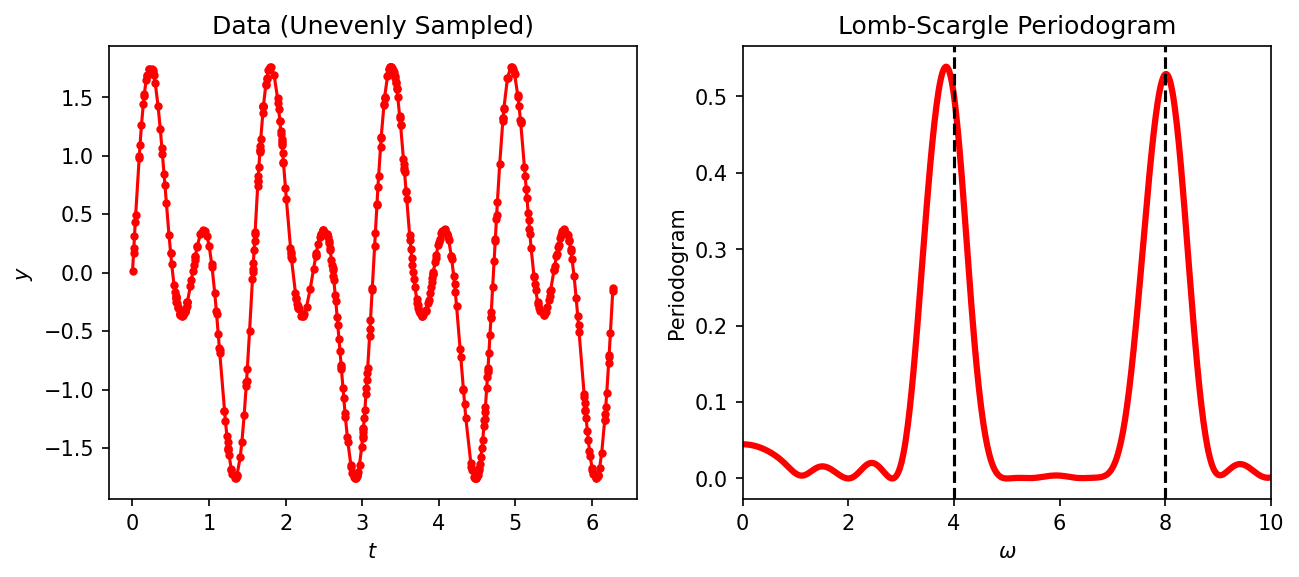

In [3]:
w0      = 4.0
# Data with random noise on uneven points
xv      = np.sort( npr.uniform(0.0, 2.0*np.pi, 500) )
data    = np.sin(w0*xv) + np.sin(2.0*w0*xv) #+ npr.normal(loc=0, scale=0.3, size=len(xv))

# Compute the Lomb-Scargle periodogram
freqs = np.linspace(1e-6,10,500)
pgram = sps.lombscargle(xv, data, freqs, normalize=True)

fig, axs = plt.subplots(1,2, dpi=150, figsize=(10,4))

axs[0].plot(xv, data, 'r.-')
axs[0].set_xlabel("$t$")
axs[0].set_ylabel("$y$")
axs[0].set_title("Data (Unevenly Sampled)")

axs[1].plot(freqs, pgram, 'r-', lw=3)
axs[1].set_xlim(0,10)
axs[1].axvline(w0, color="k", linestyle="--")
axs[1].axvline(2.0*w0, color="k", linestyle="--")
axs[1].set_xlabel("$\\omega$")
axs[1].set_ylabel("Periodogram")
axs[1].set_title("Lomb-Scargle Periodogram")

plt.show()

It does a much better job than the Fourier transform - we now have peaks at the correct frequencies!
It's also fairly easy to write your own function that evaluates the periodogram [3] (although it may be a little slow), for example, in classic Blue Peter fashion, here's one I made earlier.

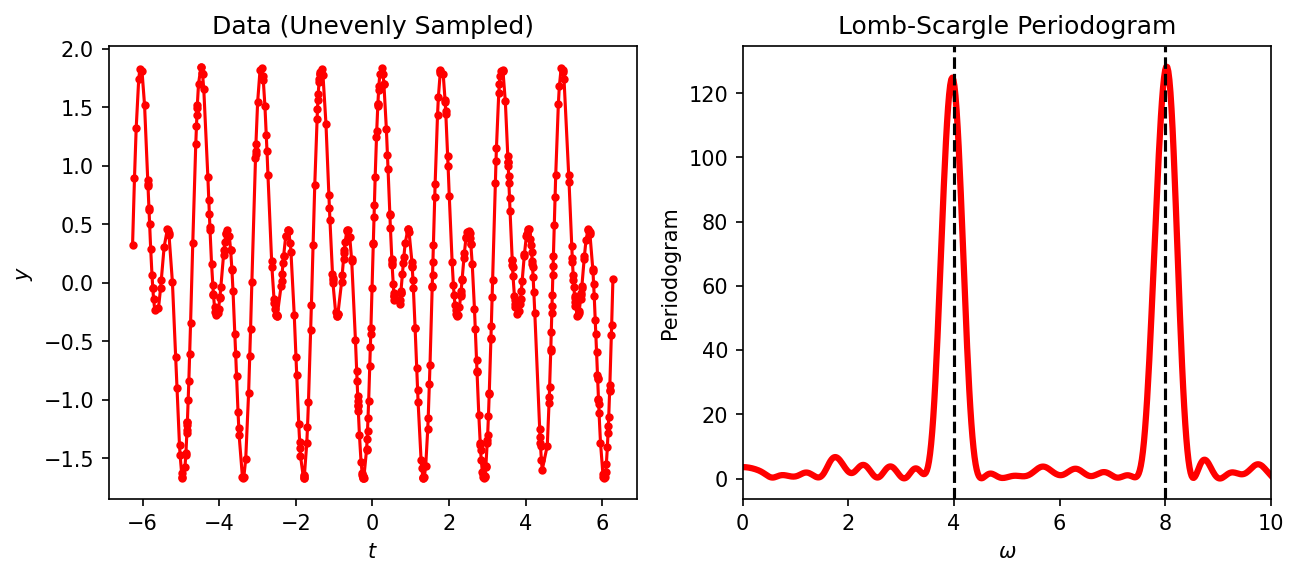

In [4]:
# A custom funtion to evaluate the Lomb-Scargle periodogram
def lomb_scargle_periodogram(xdata, ydata, freqs):
    ybar = np.average(ydata)
    ystd = np.var(ydata)
    p   = []

    ydata -= ybar # Average of the data should be zero 
    
    for w in freqs:
        # Calculate tau
        tau = np.arctan2( np.sum(np.sin(2.0*w*xdata)), np.sum(np.cos(2.0*w*xdata)) ) / (2.0*w)

        # Construct the periodogram
        term1 = np.sum( ydata * np.cos(w*(xdata-tau)) )**2 / np.sum(np.cos(w*(xdata-tau))**2)
        term2 = np.sum( ydata * np.sin(w*(xdata-tau)) )**2 / np.sum(np.sin(w*(xdata-tau))**2)

        p.append( (1.0/(2.0*ystd**2))*(term1 + term2) )
    return np.array(p) 

w0      = 4.0
xv      = np.sort( npr.uniform(-2.0*np.pi, 2.0*np.pi, 500) )
data    = np.sin(w0*xv) + np.sin(2.0*w0*xv) #+ npr.normal(loc=0, scale=0.3, size=len(xv))

freqs   = np.linspace(1e-6,10,500)
pgram   = lomb_scargle_periodogram(xv, data, freqs)
# pgram2  = sps.lombscargle(xv, data, freqs, normalize=True)

fig, axs = plt.subplots(1,2, dpi=150, figsize=(10,4))

axs[0].plot(xv, data, 'r.-')
axs[0].set_xlabel("$t$")
axs[0].set_ylabel("$y$")
axs[0].set_title("Data (Unevenly Sampled)")

axs[1].plot(freqs, pgram, 'r-', lw=3)
# axs[1].plot(freqs, pgram2/np.max(pgram2), 'w--', lw=1)
axs[1].set_xlim(0,10)
axs[1].axvline(w0, color="k", linestyle="--")
axs[1].axvline(2.0*w0, color="k", linestyle="--")
axs[1].set_xlabel("$\\omega$")
axs[1].set_ylabel("Periodogram")
axs[1].set_title("Lomb-Scargle Periodogram")

plt.show()

### Choosing $\tau$

The only thing we skipped over was how to choose $\tau$ so that $\cos (\omega t-\tau) \sin (\omega t-\tau) = 0$.
It's quite important in a few of the steps that this is true, so I'll show the working here.
We begin by using the angle-sum rules 
\begin{align}
	\sin (\alpha \pm \beta) &= \sin \alpha \cos \beta \pm \cos \alpha \sin \beta, \\
	\cos (\alpha \pm \beta) &= \cos \alpha \cos \beta \mp \sin \alpha \sin \beta,
\end{align}
to write 
\begin{equation}
	\left[ \cos \omega t \cos \tau + \sin \omega t \sin \tau \right] \left[ \sin \omega t \cos \tau - \cos \omega t \sin \tau \right] = 0.
\end{equation}
Expanding the brackets and re-organising we find that 
\begin{equation}
	\sin \omega t \cos \omega t \left[ \cos^2 \tau - \sin^2 \tau \right] + \cos \tau \sin \tau \left[ \sin^2 \omega t - \cos^2 \omega t \right] = 0 .
\end{equation}
We then use the double angle identities
\begin{align}
	\sin 2\theta &= 2 \sin \theta \cos \theta \\
	\frac{\cos 2 \theta + 1}{2} &= \cos^2 \theta \\
	\frac{1 - \cos 2\theta}{2} &= \sin^2 \theta
\end{align}
to eliminate all of the squared terms
\begin{align}
	\sin (2\omega t) \cos (2\tau) = \sin(2\tau)\cos(2\omega t) .
\end{align}
This is easily re-arranged to find that the correct choice of $\tau$ is  
\begin{equation}
	\tau = \frac{1}{2} \arctan \left[ \frac{\sin(2\omega t)}{\cos(2\omega t)} \right] .
\end{equation}

## References

[1] [N. R. Lomb, "Least Squares Spectral Analysis of Unevenly Sampled Data", *Astrophysics and Space Science* 39 pp. 447-462 (1972)](https://doi.org/10.1007/BF00648343)

[2] [J. D. Scargle, "Studies in Astronomical Time Series Analysis. II. Statistical Aspects of Spectral Analysis of Unevenly Spaced Data", 263 pp. 835-853 (1982)](https://articles.adsabs.harvard.edu/full/1982ApJ...263..835S)

[3] W. H. Press, S. A. Teukolsky, W. T. Vetterling and B. P. Flannery, "Numerical Recipes in C" (Cambridge University Press, 2007)